In [13]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.utils import shuffle
import time
import json

import itertools
import math
import scipy.optimize
from scipy import sparse
from collections import defaultdict, Counter
import string
from sklearn import linear_model
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [14]:
file = open('business_user_IDs.pkl','rb')
lasvegasID = pickle.load(file)
lasvegas = pickle.load(file)
phoenixID = pickle.load(file)
phoenix = pickle.load(file)
userID = pickle.load(file)
user = pickle.load(file)
file.close()


In [15]:
path = "./yelp_academic_dataset_review.json"

# load reviews from json data set into a list
def parseData(N=100000):
    # extract fields from review json data set 
    # setup an array for storing each json entry
    dataset = []

    # open the business source file
    f = open(path, 'r', encoding = 'utf8')
    for l in f:
        dataset.append(json.loads(l))
    f.close()
    return dataset

LV_review_data = parseData()




In [16]:
len(LV_review_data)



5996996

In [6]:
LV_review_data[0]



{'review_id': 'x7mDIiDB3jEiPGPHOmDzyw',
 'user_id': 'msQe1u7Z_XuqjGoqhB0J5g',
 'business_id': 'iCQpiavjjPzJ5_3gPD5Ebg',
 'stars': 2,
 'date': '2011-02-25',
 'text': "The pizza was okay. Not the best I've had. I prefer Biaggio's on Flamingo / Fort Apache. The chef there can make a MUCH better NY style pizza. The pizzeria @ Cosmo was over priced for the quality and lack of personality in the food. Biaggio's is a much better pick if youre going for italian - family owned, home made recipes, people that actually CARE if you like their food. You dont get that at a pizzeria in a casino. I dont care what you say...",
 'useful': 0,
 'funny': 0,
 'cool': 0}

In [7]:
# load raw data into pandas data frame and remove unwanted columns
# header_keep = ['business_id', 'user_id', 'stars', 'text', 'useful', 'funny', 'cool']
LV_review_df = pd.DataFrame(LV_review_data)


In [27]:
# filter out reviews to keep only businesses in las vegas
LV_review_df = LV_review_df[LV_review_df['business_id'].isin(lasvegas)]
LV_review_df['text_length'] = LV_review_df['text'].apply(len)
LV_review_df.head(5)




,business_id,cool,date,funny,review_id,stars,text,useful,user_id,text_length
0,iCQpiavjjPzJ5_3gPD5Ebg,0,2011-02-25,0,x7mDIiDB3jEiPGPHOmDzyw,2,The pizza was okay. Not the best I've had. I p...,0,msQe1u7Z_XuqjGoqhB0J5g,449
1,pomGBqfbxcqPv14c3XH-ZQ,0,2012-11-13,0,dDl8zu1vWPdKGihJrwQbpw,5,I love this place! My fiance And I go here atl...,0,msQe1u7Z_XuqjGoqhB0J5g,317
2,jtQARsP6P-LbkyjbO1qNGg,1,2014-10-23,1,LZp4UX5zK3e-c5ZGSeo3kA,1,Terrible. Dry corn bread. Rib tips were all fa...,3,msQe1u7Z_XuqjGoqhB0J5g,156
3,elqbBhBfElMNSrjFqW3now,0,2011-02-25,0,Er4NBWCmCD4nM8_p1GRdow,2,Back in 2005-2007 this place was my FAVORITE t...,2,msQe1u7Z_XuqjGoqhB0J5g,901
4,Ums3gaP2qM3W1XcA5r6SsQ,0,2014-09-05,0,jsDu6QEJHbwP2Blom1PLCA,5,Delicious healthy food. The steak is amazing. ...,0,msQe1u7Z_XuqjGoqhB0J5g,165


In [31]:
# average review length of 1 star reviews and the other star reviews are below
avglength = LV_review_df[LV_review_df['stars']==1]
avglength['text_length'].mean()

668.9203371771297

In [32]:
avglength = LV_review_df[LV_review_df['stars']==2]
avglength['text_length'].mean()

743.3025221924757

In [33]:
avglength = LV_review_df[LV_review_df['stars']==3]
avglength['text_length'].mean()

716.5451331902538

In [34]:
avglength = LV_review_df[LV_review_df['stars']==4]
avglength['text_length'].mean()

643.4862758767598

In [39]:
avglength = LV_review_df[LV_review_df['stars']==5]
avglength['text_length'].mean()

486.03501735654913

In [40]:
numUserReviews = LV_review_df['user_id'].value_counts()
# numUserReviews.sort_values(ascending=True)


In [42]:
# LV_review_df.iloc[1000:2000] # display review entries 1000-2000 in pandas data frame


In [43]:
len(LV_review_df) # total number of reviews for Las Vegas


1035333

In [44]:
# remove reviews where user only wrote less than 10 reviews
LV_review_df = LV_review_df[LV_review_df.isin(numUserReviews.index[numUserReviews > 10]).values]


In [45]:
len(LV_review_df) # number of reviews now that users withs less than 10 reviews are removed


330649

In [46]:
numUser = LV_review_df['user_id'].value_counts()
numBusiness = LV_review_df['business_id'].value_counts()


In [48]:
len(numUser) # number of businesses in dataset


13123

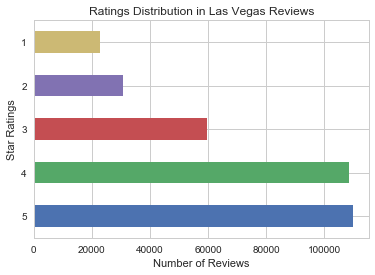

In [70]:
## save this dataframe
# LV_review_df.to_pickle("LV_reviews.pkl")

# plot star ratings distribution
LV_review_df['stars'].value_counts().plot(kind='barh')
plt.title('Ratings Distribution in Las Vegas Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Star Ratings')
plt.savefig('ratings_distrib.png')


In [50]:
label = LV_review_df['stars'].tolist()
review = LV_review_df['text'].tolist()
userID = LV_review_df['user_id'].tolist()
businessID = LV_review_df['business_id'].tolist()
review, label, userID, businessID = shuffle(review, label, userID, businessID, random_state=5)


In [52]:
## shuffle the dataset and keep use only 100K reviews for project
K = 100000
review = review[:K]
label = label[:K]
userID = userID[:K]
businessID = businessID[:K]

# # save to pickle file
# file = open('yelp_200K_LV.pkl','wb')
# pickle.dump(review, file)
# pickle.dump(label, file)
# pickle.dump(userID, file)
# pickle.dump(businessID, file)
# file.close()



In [55]:
avg = pd.DataFrame({'review': review,'rating': label,'userID': userID,'businessID': businessID})

In [57]:
avg['text_length'] = avg['review'].apply(len)
avg.head(5)

,businessID,rating,review,userID,text_length
0,NvKNe9DnQavC9GstglcBJQ,4,I dont give it 5 stars because it could be a l...,1dwa6Wkp0chKBcrRuO05lA,269
1,MXC9pwIxovWUc9yu1F8OxA,5,"We came here on a Saturday night, around 9ish,...",rHgT6lBbZ2PaHt0UWfTMtw,1149
2,BjS35X3-_-9TP-RyfzoC_Q,1,Food is pretty ok. The service is good. I shou...,j9vih1KD2r-NLlaHfZPkRA,366
3,mDR12Hafvr84ctpsV6YLag,4,"Friendly service, good prices and big portions...",ukkRTJLkQTx95fCalVn6BA,1827
4,3Jq5LfJ5fmJ5KmuA6VHmzw,5,So excited to be a part of this amazing team! ...,k1VrwDJi2OOrmRfkiIzNug,130


In [64]:
avglength = avg[avg['rating']==4]
avglength['text_length'].mean()


781.841757706704

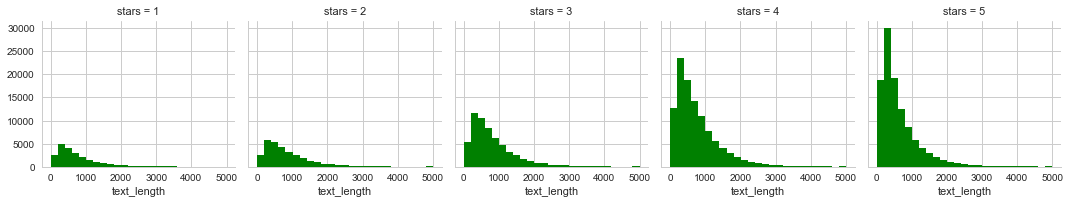

In [75]:
sns.set(style="whitegrid")

# how does review length factor into star rating?
g = sns.FacetGrid(data=LV_review_df, col='stars', margin_titles=True, palette="Set1")
g.map(plt.hist, 'text_length', bins=25, color='g')
g.savefig("stars_vs_length.png")